In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import load_data
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import plot_learning_curve
from sklearn.model_selection import ShuffleSplit
from matplotlib import cm
import importlib
import cdms2 as cdms
import MV2 as MV
from sklearn.preprocessing import MinMaxScaler

In [2]:
sites = ['sgp','goamazon']
sites = ['sgp']
feature_path = "/global/homes/z/zhangtao/ML_trigger/ML/data/"
feature_files = ["Arm_CF_1999_2009_hy.nc"]
cape_names = ['dilute_dcape','dilute_cape','undilute_dcape','undilute_cape']
cape_names_sh = ['dd','dc','udd','udc']
scam_dir="/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/"

In [3]:
def load_ArmData(path):
    fid = cdms.open(path)
    prect = fid('prec_srf')
    q = fid('q')
    T = fid('T')
    u = fid('u')
    v = fid('v')
    T_adv_h = fid('T_adv_h')
    s_adv_h = fid('s_adv_h')
    LH = fid('LH')
    SH = fid('SH')
    RH_srf = fid('RH_srf')
    T_srf = fid('T_srf')
    
    # lower (700–800hPa), upper (200–300hPa),middle(300–700 hPa)    600hpa  
    #Chen Q, et al. Roles of wind shear at different vertical levels: Cloud 
    #system organization and properties.
    
    #vertical wind shear
    u_low = u[:,8] #800hpa
    u_mid = u[:,12] #700hpa
    u_high = u[:,28] # 300hpa
    u_top = u[:,32] # 200hpa
    
    v_low = v[:,8] #800hpa
    v_mid = v[:,12] #700hpa
    v_high = v[:,28] # 300hpa
    v_top = v[:,32] # 200hpa
    
    u_shear_low = u_mid - u_low
    u_shear_mid = u_high - u_mid
    u_shear_high = u_top - u_high
    
    v_shear_low = v_mid - v_low
    v_shear_mid = v_high - v_mid
    v_shear_high = v_top - v_high
    
    shear_low = (u_shear_low**2 + v_shear_low**2)**0.5
    shear_mid = ( u_shear_mid**2 + v_shear_mid**2 )**0.5
    shear_high = ( u_shear_high**2 + v_shear_high**2 )**0.5
    
    #shear_low = u_shear_low + v_shear_low 
    #shear_mid = u_shear_mid + v_shear_mid
    #shear_high = u_shear_high + v_shear_high
    
    #T and Q average
    T_low = MV.average(T[:,8:12+1],axis=1) #800hpa - 700hpa
    T_mid = MV.average(T[:,12:28+1],axis=1) #700hpa - 300hpa
    T_high = MV.average(T[:,28:32+1],axis=1) # 300hpa - 200hpa
    
    q_low = MV.average(q[:,8:12+1],axis=1) 
    q_mid = MV.average(q[:,12:28+1],axis=1) 
    q_high = MV.average(q[:,28:32+1],axis=1) 
    
    #Advective Tendency average
    T_adv_h_low = MV.average(T_adv_h[:,8:12+1],axis=1) 
    T_adv_h_mid = MV.average(T_adv_h[:,12:28+1],axis=1) 
    T_adv_h_high = MV.average(T_adv_h[:,28:32+1],axis=1) 
    
    s_adv_h_low = MV.average(s_adv_h[:,8:12+1],axis=1) 
    s_adv_h_mid = MV.average(s_adv_h[:,12:28+1],axis=1) 
    s_adv_h_high = MV.average(s_adv_h[:,28:32+1],axis=1)  
    
    #single level variable
    
    dataset = pd.DataFrame()
    
    dataset['LH'] = LH
    dataset['SH'] = SH
    dataset['RH_srf'] = RH_srf
    dataset['T_srf'] = T_srf
    
    dataset['shear_low'] = v_shear_low
    dataset['shear_mid'] = v_shear_mid
    dataset['shear_high'] = v_shear_high
    dataset['T_low'] = T_low
    dataset['T_mid'] = T_mid
    dataset['T_high'] = T_high
    dataset['q_low'] = q_low
    dataset['q_mid'] = q_mid
    dataset['q_high'] = q_high
    dataset['T_adv_h_low'] = T_adv_h_low
    dataset['T_adv_h_mid'] = T_adv_h_mid
    dataset['T_adv_h_high'] = T_adv_h_high
    dataset['s_adv_h_low'] = s_adv_h_low
    dataset['s_adv_h_mid'] = s_adv_h_mid
    dataset['s_adv_h_high'] = s_adv_h_high
    
    dataset['prect'] = prect
    
    #dataset['trigger'] = np.where(prect > 0.5,1,0)
    #print(q.getAxis(1))
    #print(q.getAxis(1)[:])
    #print(prect.shape)
    #print(q.shape)
    
    return dataset
    
#load_ArmData(feature_path+"Arm_CF_1999_2009.nc")

In [4]:
dataset_all = {}
dataset_train_all = {}
dataset_test_all = {}

# load data

In [5]:
# read features

for site in sites:
    # load 4 cape triggers
    cape4s = {}
    for cape,cape_sh in zip(cape_names,cape_names_sh):
        cape4s[cape_sh] = np.loadtxt(scam_dir+site+"_"+cape+"_tiedke_0.5.txt")
        
        if site == 'sgp':
            dataset = load_ArmData(feature_path+"Arm_CF_1999_2009.nc")
        elif site == 'goamazon':
            dataset = load_ArmData(feature_path+"goamazon_2014_2015.nc")

        cin = np.loadtxt(feature_path+"cin_"+site+".txt")
        dataset['cin'] = cin
        dataset['ddcape'] = cape4s['dd']
        dataset['trigger'] = np.where(dataset.loc[:,'prect']>=0.5, 1, 0)
        prect = dataset.loc[:,'prect']
        
        dataset.drop(columns='prect',inplace=True)
        dataset['prect'] = prect
        
        #dataset[['prect','ddcape']] = dataset[['ddcape','prect']]
        #dataset.rename(columns={'prect':'cape'}, inplace=True)
        #dataset.rename(columns={'ddcape':'prect'}, inplace=True)
        
        #if site == 'sgp':
        #    dataset = dataset.iloc[::3,:]
    
    dataset_all[site] = dataset

In [6]:
dataset_all['sgp'].iloc[:,:23].head()

,LH,SH,RH_srf,T_srf,shear_low,shear_mid,shear_high,T_low,T_mid,T_high,...,T_adv_h_low,T_adv_h_mid,T_adv_h_high,s_adv_h_low,s_adv_h_mid,s_adv_h_high,cin,ddcape,trigger,prect
0,75.466141,7.962654,67.626862,26.569201,-2.53340,-0.439800,2.277530,287.479797,261.649536,227.376801,...,0.302780,-0.041080,0.142072,0.236668,-0.101891,0.104103,-180.257112,118.7672,0,0.052067
1,24.207590,-0.258206,73.269478,25.152603,-2.60500,0.710010,2.058910,287.409790,261.649170,227.656403,...,0.265769,-0.067765,0.170913,0.235860,-0.095660,0.156116,-158.939301,187.9128,0,0.436567
2,2.120878,1.778930,78.389183,23.797127,-2.65099,2.490150,1.903800,287.400818,261.629364,227.907013,...,0.232422,-0.143987,0.153575,0.260052,-0.115239,0.182571,-144.168442,267.2368,1,0.969400
3,-2.306376,12.764638,81.118980,22.754717,-2.54720,3.758360,2.322770,287.463379,261.557800,227.999420,...,0.201240,-0.283218,0.039900,0.215509,-0.275333,0.026891,-140.555413,391.7533,1,1.625967
4,-13.743360,21.948606,82.284218,21.948774,-2.37520,3.851871,3.096439,287.494995,261.392853,227.882416,...,0.209696,-0.366890,-0.103215,0.184140,-0.408048,-0.180879,-139.208250,432.5973,1,1.869100


# load arm97

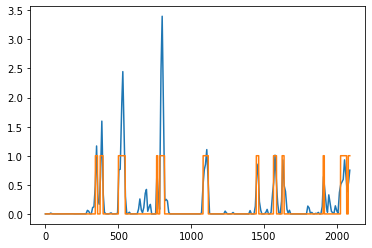

In [7]:
arm97_path="/global/homes/z/zhangtao/ML_trigger/ML/data/ARM97_4scam_uniform.nc"
arm97_cape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/arm97_dcape.txt")
arm97_cin = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/ncar_metpy/cin_arm97.txt")
arm97 = load_ArmData(arm97_path)

arm97['cin'] = arm97_cin
arm97['ddcape'] = arm97_cape
arm97['trigger'] = np.where(arm97.loc[:,'prect']>=0.5,1.0,0.0)
prect = arm97.loc[:,'prect']

arm97.drop(columns='prect',inplace=True)
arm97['prect'] = prect

plt.plot(arm97.loc[:,'prect'])
plt.plot(arm97.loc[:,'trigger'])

# load twp06

In [8]:
twp06_path="/global/homes/z/zhangtao/ML_trigger/ML/data/TWP06_4scam_uniform.nc"
twp06_cape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/ML/data/twp06_dcape.txt")
twp06_cin = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/ML/data/cin_twp06.txt")
twp06 = load_ArmData(twp06_path)

twp06['cin'] = twp06_cin
twp06['ddcape'] = twp06_cape
twp06['trigger'] = np.where(twp06.loc[:,'prect']>=0.5,1,0)
prect = twp06.loc[:,'prect']

twp06.drop(columns='prect',inplace=True)
twp06['prect'] = prect



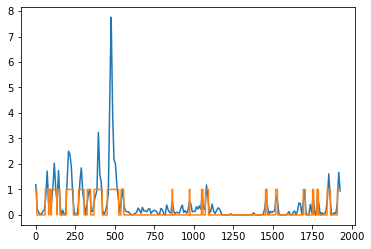

In [9]:
plt.plot(twp06.loc[:,'prect'])
plt.plot(twp06.loc[:,'trigger'])

# verify cape value

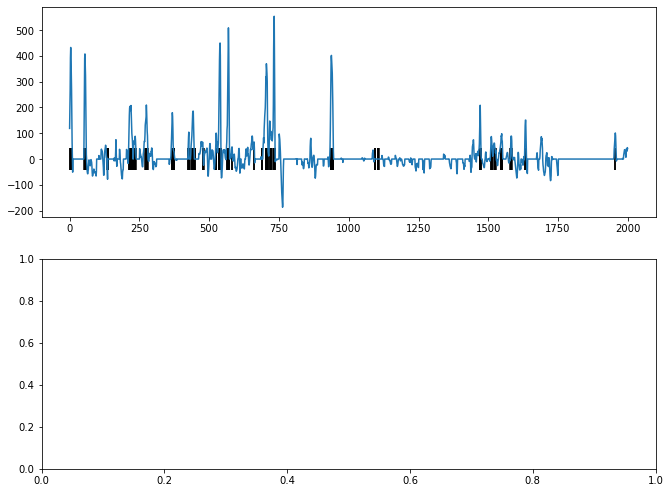

In [25]:
fig,axes = plt.subplots(2,1,figsize=(11,8.5),squeeze=False)

for n,site in enumerate(sites):
    dataset = dataset_all[site]
    n_sample = dataset.shape[0]
    real_trigger = np.zeros(n_sample)
    
    for i in range(n_sample):
        if dataset.loc[i,'prect'] > 0.5:
            real_trigger[i] = 1
        else:
            real_trigger[i] = np.nan
    
    axes[n][0].scatter(range(2000),real_trigger[:2000], color='k',marker='|',s=500)
    axes[n][0].plot(range(2000), dataset.loc[:2000-1,'ddcape'])
    #axes[n][0].set_title(site)

# divide training and testing data

In [139]:
dataset_all['sgp'] = twp06

for site in sites:
    dataset_x = dataset_all[site].iloc[:,:21+1]
    dataset_y = dataset_all[site].iloc[:,21]
    
    #scaler = MinMaxScaler()
    #dataset_x = pd.DataFrame(scaler.fit_transform(dataset_x),columns=dataset_x.columns)
    
    dataset_x_train, dataset_x_test, dataset_y_train, dataset_y_test=train_test_split(
        dataset_x, dataset_y, test_size=0.3, random_state=20)
    
    dataset_train_all[site] = dataset_x_train
    dataset_test_all[site] = dataset_x_test


#dataset_train_all['sgp'] = dataset_all['sgp'].iloc[:,:21+1]
#dataset_test_all['sgp'] = arm97.iloc[:,:22]
#dataset_test_all['sgp'] = twp06.iloc[:,:22] 

#print(dataset_train_all['sgp'].shape)
#print(dataset_test_all['sgp'].shape)

#dataset_train_all['sgp'] = pd.concat([dataset_train_all['sgp'],arm97.iloc[:400,:22]])
#dataset_test_all['sgp'] = arm97.iloc[400:,:22] 

#print(dataset_train_all['sgp'].shape)
#print(dataset_test_all['sgp'].shape)

# performance of cape triggers

In [140]:
cape_thres = 65

for site in sites:
    print(site)
    
    dataset_test = dataset_test_all[site]
    real_trigger = dataset_test_all[site].iloc[:,21]
    
    n_test = dataset_test.shape[0]
    
    cape_trigger = np.zeros(n_test)
    for i in range(n_test):
        if dataset_test.iloc[i,20] > cape_thres:
            cape_trigger[i] = 1
            
    tn, fp, fn, tp = confusion_matrix(real_trigger, cape_trigger).ravel()
    f1 = f1_score(real_trigger, cape_trigger,average='macro')
    p  = precision_score(real_trigger, cape_trigger,average='macro')
    r  = recall_score(real_trigger, cape_trigger,average='macro')

    print(tp,fp,fn,tn)
    print(f1, p, r)
    

sgp
114 5 24 436
0.9274865367922369 0.9529046401169163 0.9073745440205068


# performance of xgb trigger

sgp
132 3 6 438
0.9784317377537717 0.9821321321321321 0.9748595090209997


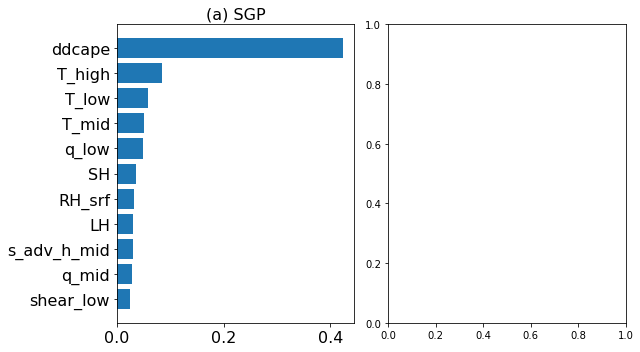

In [141]:
fig, axes = plt.subplots(1,2,figsize=(9,5), squeeze=False)
titles = ["(a) SGP", "(b) MAO"]
fh = 16

for n,site in enumerate(sites):
    dataset_train_x = dataset_train_all[site].iloc[:,:21]
    dataset_train_y = dataset_train_all[site].iloc[:,21]
    
    dataset_test_x = dataset_test_all[site].iloc[:,:21]
    dataset_test_y = dataset_test_all[site].iloc[:,21]
    
    #xgb = XGBClassifier(n_estimators=5, nthread=20, max_depth=3,scale_pos_weight=3.5)
    xgb = XGBClassifier(n_estimators=600, nthread=20, max_depth=7,scale_pos_weight=3.5)
    xgb.fit(dataset_train_x, dataset_train_y)
    
    data_predic_y = xgb.predict(dataset_test_x)
    
    tn, fp, fn, tp = confusion_matrix(dataset_test_y, data_predic_y).ravel()
    f1 = f1_score(dataset_test_y, data_predic_y, average='macro')
    p  = precision_score(dataset_test_y, data_predic_y, average='macro')
    r  = recall_score(dataset_test_y, data_predic_y, average='macro')

    print(site)
    print(tp,fp,fn,tn)
    print(f1,p,r)
    
    #display importance
    importance = xgb.feature_importances_
    name = dataset_all[site].columns.values.tolist()[:21]
    imp = pd.DataFrame({"imp":importance, "name":name})
    imp.sort_values('imp',inplace=True,ascending=False)
    imp.reset_index(inplace=True)
    axes[0][n].invert_yaxis()
    axes[0][n].barh(imp.loc[:10,'name'],imp.loc[:10,'imp'])
    axes[0][n].set_title(titles[n],fontsize=fh)
    axes[0][n].tick_params(labelsize=fh)
    
plt.tight_layout()
plt.savefig("figs/imp.pdf")

# MLER

In [66]:
for site in sites:
    print(site)
    
    dataset_test = dataset_test_all[site]
    real_trigger = np.array(dataset_test_all[site].iloc[:,21]) * 1.0

    n_test = dataset_test.shape[0]    
    cape_trigger = np.zeros(n_test)
    
    for i in range(n_test):
        if dataset_test.iloc[i,20] > 168:
            cape_trigger[i] = 1
        elif dataset_test.iloc[i,20] < 26 and dataset_test.iloc[i,2] < 87:
            cape_trigger[i] = 0
        else:
            cape_trigger[i] = np.nan
            real_trigger[i] = np.nan
    

    cape_trigger = cape_trigger[~np.isnan(cape_trigger)]
    real_trigger = real_trigger[~np.isnan(real_trigger)]
    
    tn, fp, fn, tp = confusion_matrix(real_trigger, cape_trigger).ravel()
    f1 = f1_score(real_trigger, cape_trigger,average='macro')
    p  = precision_score(real_trigger, cape_trigger,average='macro')
    r  = recall_score(real_trigger, cape_trigger,average='macro')

    print(tp,fp,fn,tn)
    print(f1, p, r)
    

sgp
38 0 56 1425
0.7782435504390082 0.9810938555030385 0.7021276595744681
